# Full circuit for 1+1d SU(2) Trotter simulation using the LSH formulation with $L=4$, $\Lambda=2$

Using a qutrit to represent the bosonic dof at r=2.

The possible quantum numbers at each site are:
- r=0:
  - (ni, no) = (0, 0), (0, 1), (1, 1)
  - nl = 0
- r=1:
  - (ni, no) = all combinations
  - nl = 0, 1
- r=2: all combinations
- r=3: (ni, no, nl) = (0, 0, 1), (0, 1, 0), (1, 0, 1), (1, 1, 1)

Considering first-order Trotter for the moment.

## On the non-use of relative-phase Toffoli

- Double-controlled incrementer in the hopping terms seems like a prime application of CNOT cost reduction by the use of relative-phase Toffolis.
- However, there is the Hadamard acting on one of the qubits, which require that the relative phases factor out (acts identically) on this qubit.
- As an example, if the qubit with the Hadamard is taken to be the most significant, the relative-phase Toffoli must have a form $\mathrm{diag}(z_0, z_1, z_2, z_3, z_0, z_1, \begin{pmatrix} & z_2 \\ z_3 & \end{pmatrix})$, i.e., the full Toffoli multiplied by $\mathrm{diag}(z_0, z_1, z_2, z_3, z_0, z_1, z_2, z_3)$ from the left.
- A parity network can never create a Toffoli-like structure alone (there will be at least two pairs of basis exchange). Typical construction of a Toffoli is by a parity network sandwitched by two Hadamards. (Here we have not ruled out possibilities of other constructions, but I suspect any apparently different one turns out to be equivalent to H-parity-H)
- The "X" part of relative-phase Toffoli under such a construction would be either an X or a Y. If it is a Y, the parity network must result in a Y at the same location because $HYH \propto Y$. This conflicts with the requirement of factoring out a qubit because 

## Qubit placement

- All double-control gates appear in inverting pairs. Relative-phase Toffolis suffice to realize the desired effect.
  - Relative-phase Toffolis are CNOT-efficient only when the target qubit is in the middle in a linear topology.
- The interaction Hamiltonian contains high-weight diagonals which are the most efficient when certain qubits are at the edges.

Above considerations lead to the following qubit placement and routing:

1. o-l-i=i+l+o-o-l-i= ... -> CX[i(r)-i(r+1)] and CClambda[i(r+1), o(r+1), l(r+1)] of U_svd(1)
1. o-i-l-i-l-o-o-i-l- ... -> SWAP l(r) and i(r)
1. i-o-l-i-l-o-i-o-l- ... -> SWAP o(r) and i(r)
1. i-o=l=i-l-o-i-o=l= ... -> CClambda[i(r+1), o(r), l(r)] of U_svd(1)
1. i-o-l-i-o-l-i-o-l- ... -> SWAP o(r+1) and l(r+1)
1. i-o-l-o-i-l-i-o-l- ... -> SWAP i(r+1) and o(r+1)
1. i=o=l=o=i-l-i=o=l= ... -> diagonal term G(1)
1. i-o-l-i-o-l-i-o-l- ... -> SWAP i(r+1) and o(r+1)
1. i-o-l-i-l-o-i-o-l- ... -> SWAP o(r+1) and l(r+1)
1. i-o=l=i-l-o-i-o=l= ... -> CClambda[i(r+1), o(r), l(r)] of U_svd(1)
1. o-i-l-i-l-o-o-i-l- ... -> SWAP o(r) and i(r)
1. o-l-i-i-l-o-o-l-i- ... -> SWAP l(r) and i(r)
1. o+l+i-i-l-o=o+l+i- ... -> CX[o(r+1)-o(r+2)] and CClambda[i(r+2), o(r+2), l(r+2)] of U_svd(2)
1. ...


In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import os
import sys
sys.path.append('/home/iiyama/src/qutrit-experiments')
sys.path.append('/home/iiyama/src/lsh-qudit')
from copy import deepcopy
from collections import defaultdict
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, transpile, qpy
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qutrit_experiments.gates import (X12Gate, P1Gate, P2Gate, RZ12Gate, QGate, XplusGate,
                                      XminusGate, QubitQutritCRxMinusPiGate, QubitQutritCRxPlusPiGate)
%aimport lsh_qudit.hamiltonian
from lsh_qudit.hopping_terms import hi1r0_svd, hi1r0_diag, hi1r1_diag
from lsh_qudit.validator import circuit_unitary, validate_circuit, validate_unitary
from lsh_qudit.utils import QubitPlacement, remove_idle_wires, op_matrix, physical_states, sort_qubits, draw_circuit, clean_array, diag_to_iz
from lsh_qudit.hamiltonian import mass_term, electric_12_term, electric_3f_term, electric_3b_term, hopping_term, hi1_mat, hi2_mat

## Model parameters

In [3]:
num_sites = 4
mass_mu = Parameter('$\mu$')
interaction_x = Parameter('x')

time_step = Parameter('$\Delta$t')
# Random not-so-small numbers for numerical validation
dt = 0.73
mu = 0.37
x = 0.87

custom_gates = ['rccx_cct', 'rccx_cct_dg', 'rccx_ctc', 'rccx_ctc_dg', 'cq', r'c$\lambda^{-}$', r'c$\lambda^{-}$_dg']

backend = FakeTorino()
# Initial mapping of occupation numbers to physical qubits (i and o get swapped)
#                d2
# o0-i0-i1-l1-o1-l2-o2-i2-i3-l3-o3

initial_fermion_i = [61, 62, 67, 68]
initial_fermion_o = [60, 64, 65, 70]
initial_boson = [None, 63, 73, 69]
initial_ancilla = [66]
fix_right_boundary = False

In [4]:
full_circuit = QuantumCircuit(12)

## $H_M$

$$
\begin{align*}
H_{M}(r) &= H_{M}^{(1)}(r) + H_{M}^{(2)}(r)\,, \\
H_{M}^{(1)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{i(r)}\,,\\
H_{M}^{(2)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{o(r)}\,
\end{align*}
$$

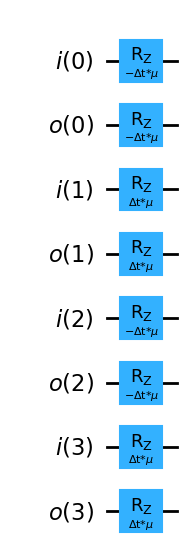

In [5]:
qp = QubitPlacement(sum(([('i', site), ('o', site)] for site in range(4)), []))
mass_circuit = QuantumCircuit(qp.num_qubits)
for site in range(4):
    circuit, init_p, _ = mass_term(site, time_step, mass_mu)
    mass_circuit.compose(circuit, qubits=[qp[lab] for lab in init_p.qubit_labels], inplace=True)
draw_circuit(mass_circuit, qp, reorder=False)

In [6]:
assigned = sort_qubits(mass_circuit, qp).assign_parameters({mass_mu: mu, time_step: dt})
op = np.zeros((2,) * (2 * num_sites))
pauliz = np.array([1., -1.])
for site in range(4):
    for io in range(2):
        dim = 2 * (4 - site) - io - 1
        extra_dims = list(range(dim)) + list(range(dim + 1, 8))
        op += np.expand_dims(pauliz * (-1 + 2 * (site % 2)), extra_dims)
op *= mu / 2. * dt
hmat = np.diagflat(op)
validate_circuit(assigned, hmat, diagonal=True)

True

## $H_E$

$$
\begin{align}
H_{E}&=H_{E}^{(1)} + H_{E}^{(2)} + H_{E}^{(3)}
\\
H_{E}^{(1)} & = \frac{1}{2}n_{l}(r)\,,
\\
H_{E}^{(2)} & = \frac{1}{4}n_{l}(r)^{2}\,,
\\
H_{E}^{(3)} & = \frac{1}{2}\left[n_{l}(r)+\frac{3}{2}\right] n_{o}(r) \left(1-n_{i}(r)\right)\,.
\end{align}
$$

### $H_E^{(1)} + H_E^{(2)} = \frac{1}{2}n_{l}(r) + \frac{1}{4}n_{l}(r)^{2}$

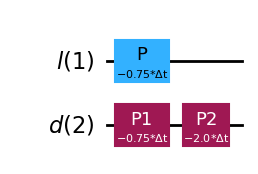

In [7]:
labels = [('l', 1), ('d', 2)]
qp = QubitPlacement(labels)
electric_12_circuit = QuantumCircuit(qp.num_qubits)
for site, bc in enumerate([{'left_flux': 0}, {'left_flux': (0, 1)}, {}]):
    circuit, init_p, _ = electric_12_term(site, time_step, **bc)
    electric_12_circuit.compose(circuit, qubits=[qp[lab] for lab in init_p.qubit_labels], inplace=True)
draw_circuit(electric_12_circuit, qp, reorder=False, fold=100)

In [8]:
assigned = sort_qubits(electric_12_circuit, qp).assign_parameters({time_step: dt})
op = np.zeros((3, 2))
op[:, 1] += 0.75
op[:] += np.array([0., 0.75, 2.])[:, None]
op *= dt
hmat = np.diagflat(op)
validate_circuit(assigned, hmat, qutrits=(1,))

True

### $H_E^{(3)} = \frac{1}{2}\left[n_{l}(r)+\frac{3}{2}\right] n_{o}(r) \left(1-n_{i}(r)\right)$

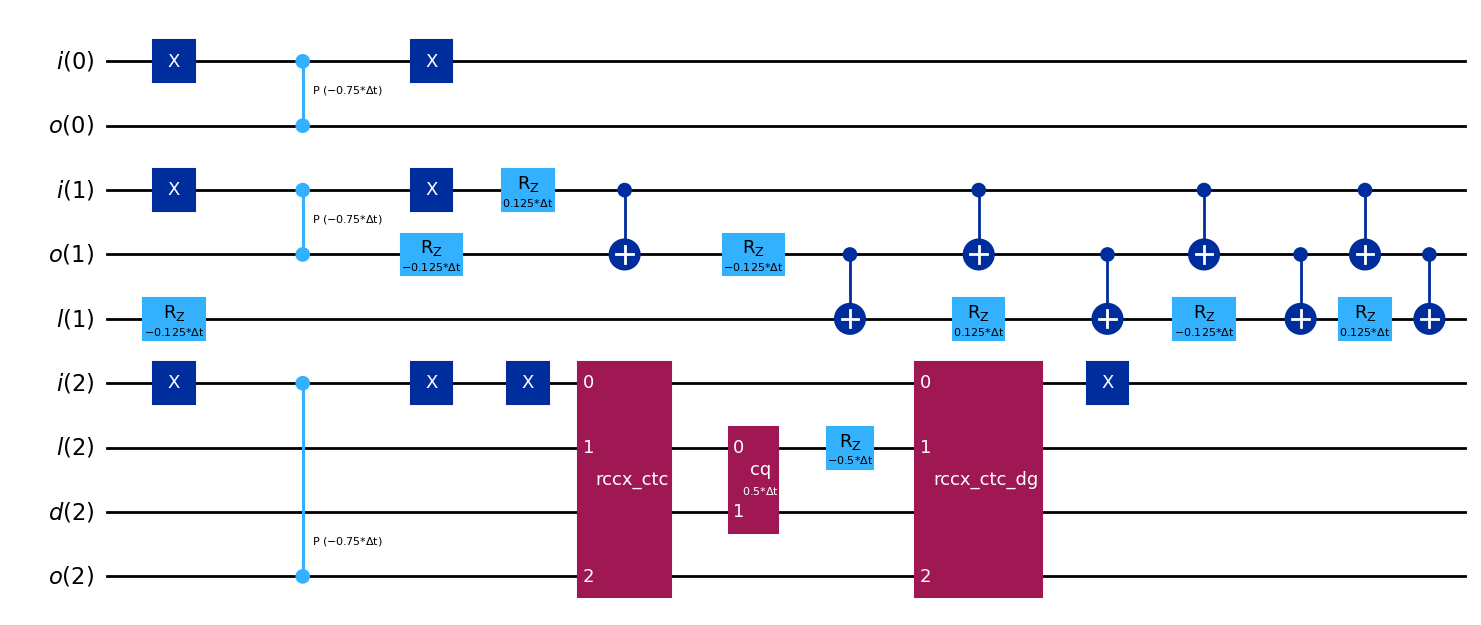

In [9]:
labels = [('i', 0), ('o', 0)]
labels += [('i', 1), ('o', 1), ('l', 1)]
labels += [('i', 2), ('l', 2), ('d', 2), ('o', 2)]
qp = QubitPlacement(labels)
electric_3_circuit = QuantumCircuit(qp.num_qubits)
for site, bc in enumerate([{'left_flux': 0}, {'left_flux': (0, 1)}, {}]):
    circuit, init_p, _ = electric_3f_term(site, time_step)
    electric_3_circuit.compose(circuit, qubits=[qp[lab] for lab in init_p.qubit_labels], inplace=True)
    circuit, init_p, _ = electric_3b_term(site, time_step, **bc)
    electric_3_circuit.compose(circuit, qubits=[qp[lab] for lab in init_p.qubit_labels], inplace=True)
draw_circuit(electric_3_circuit, qp, reorder=False, fold=100)

In [10]:
assigned = sort_qubits(electric_3_circuit.decompose(custom_gates), qp).assign_parameters({time_step: dt})
op = np.zeros((3, 2, 2, 2, 2, 2, 2, 2))
op[:, :, :, :, :, :, 1, 0] += 0.75
op[:, :, :, :, 1, 0] += 0.75
op[:, :, :, 1, 1, 0] += 0.5
op[:, 1, 0] += 0.75
op[1, 1, 0] += 0.5
op[2, 1, 0] += 1.
op *= dt
hmat = np.diagflat(op)
validate_circuit(assigned, hmat, qutrits=(8,), ancillae=(7,))

True

## $H_I$

### $H_I^{(1)}$

The general form of $H_I^{(1)}$ is

$$
\begin{split}
\frac{1}{x} H_I^{(1)}(r) = & H_I^{(1)+}(r) + H_I^{(1)-}(r) \\
= & \ket{0}\bra{1}_{i(r)} Z_{o(r)} \ket{1}\bra{0}_{i(r+1)} \left[ \lambda^+_{l(r)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \right]^{1 - n_o(r)} \left[ \lambda^+_{l(r+1)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \right]^{n_o(r+1)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right) \\
& + \ket{1}\bra{0}_{i(r)} Z_{o(r)} \ket{0}\bra{1}_{i(r+1)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right)
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \lambda^-_{l(r)} \right]^{1 - n_o(r)}
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \lambda^-_{l(r+1)} \right]^{n_o(r+1)}
\end{split}
$$

Note that the combinations of the allowed $n_i$ and $n_o$ values together with AGL dictates that a
non-annihilated state will have $n_l(r) = n_l(r+1)$.


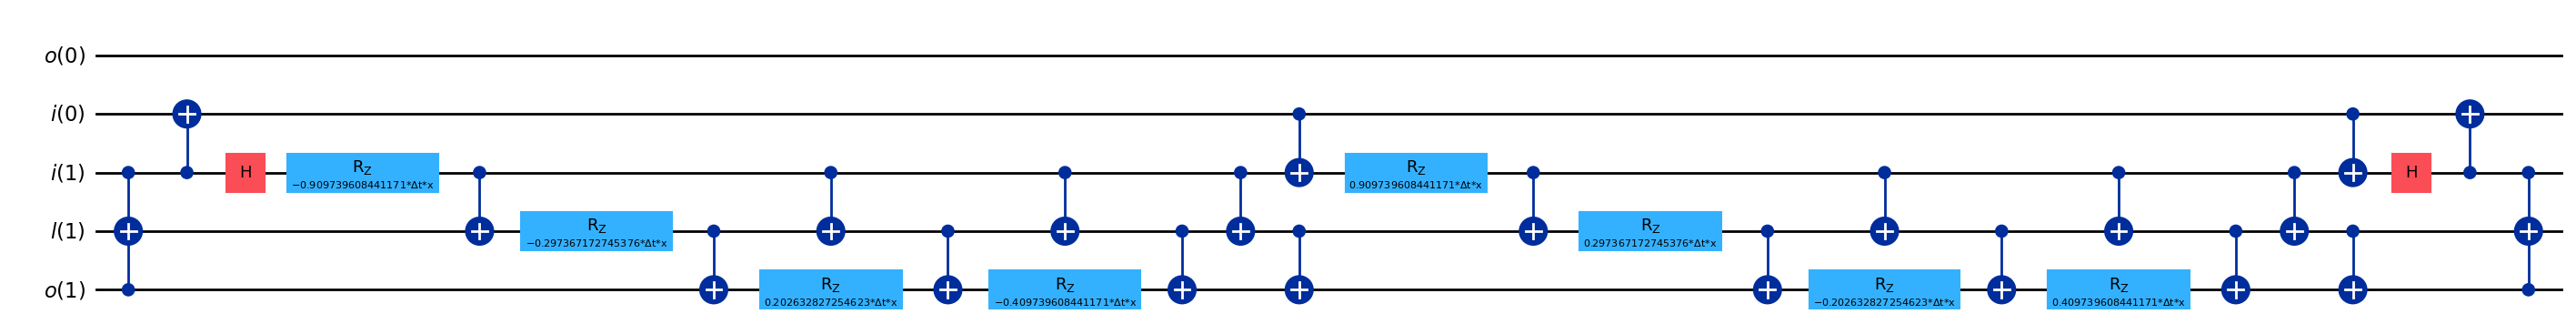

In [11]:
circuit, init_p, _ = hopping_term(1, 0, time_step, interaction_x, left_flux=0)
draw_circuit(circuit, init_p, reorder=False, fold=50)

In [12]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
# Reverse the site ordering through embedding
embedded_qp = QubitPlacement([('l', 1), ('o', 1), ('i', 1), ('l', 0), ('o', 0), ('i', 0)])
embedded = QuantumCircuit(embedded_qp.num_qubits)
embedded.compose(assigned, qubits=[embedded_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi1_mat.reshape(4, 3, 4, 3, 4, 3, 4, 3)[:, :2, :, :2, :, :2, :, :2].reshape(64, 64) * x * dt
subspace = np.sum(physical_states(left_flux=0, num_sites=2, as_multi=True) << np.arange(6)[None, ::-1], axis=1)
validate_circuit(embedded, hmat, subspace=subspace)

True

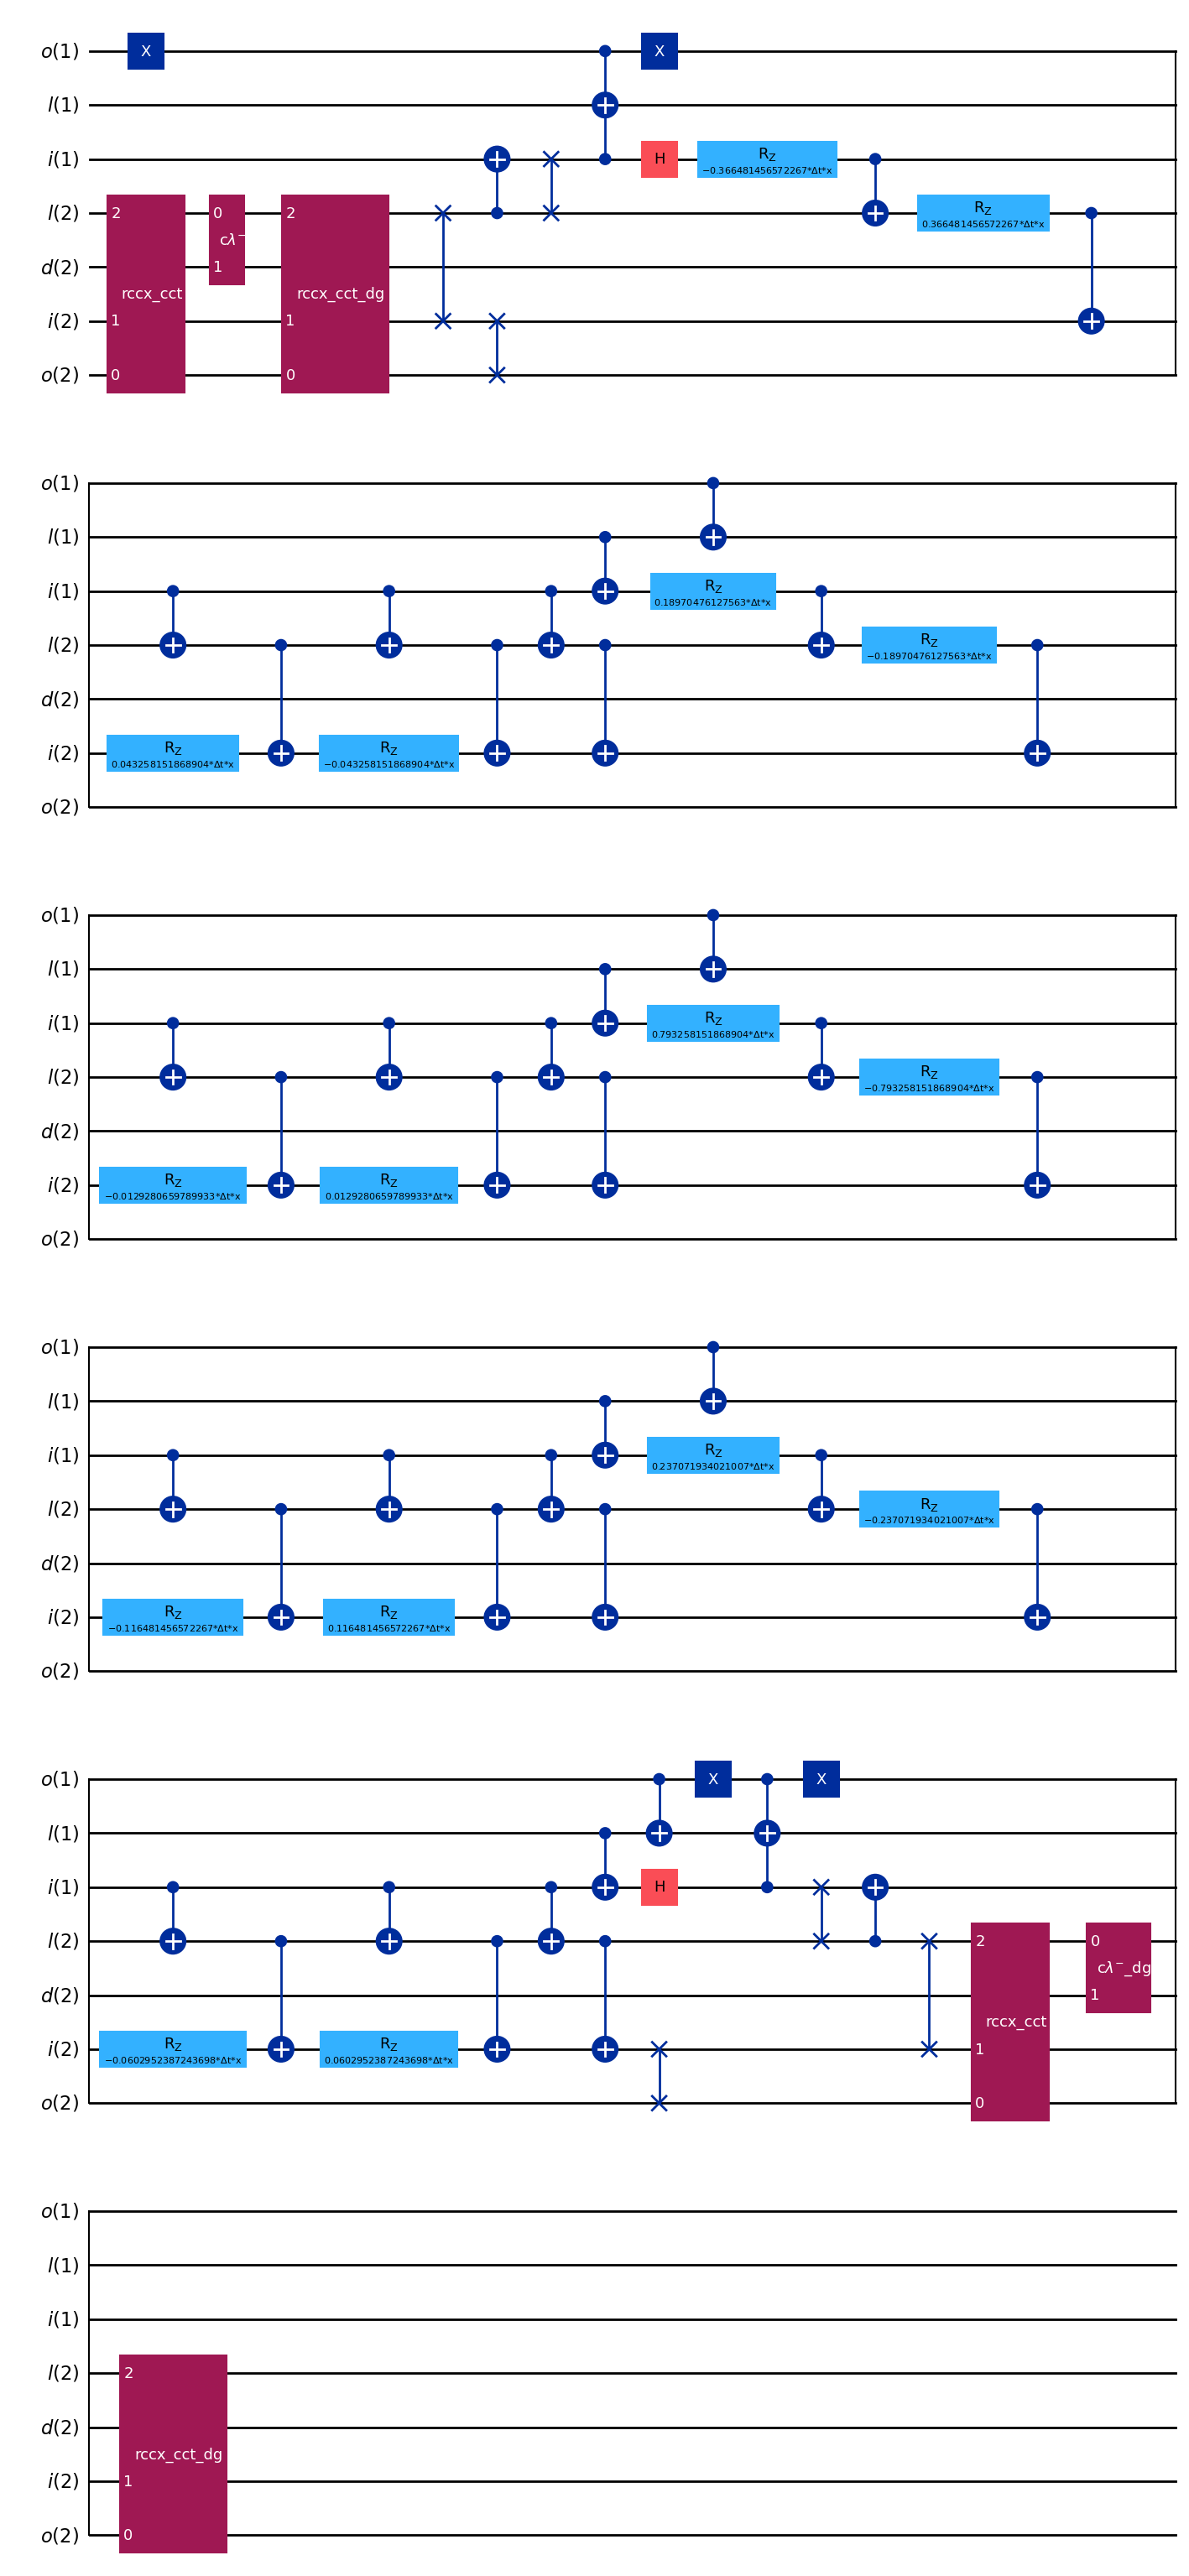

In [13]:
circuit, init_p, _ = hopping_term(1, 1, time_step, interaction_x, left_flux=(0, 1))
draw_circuit(circuit, init_p, reorder=False, fold=20)

In [14]:
assigned = circuit.decompose(custom_gates).assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('l', 2), ('d', 2), ('o', 2), ('i', 2), ('l', 1), ('o', 1), ('i', 1)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi1_mat.reshape(4, 3, 12, 4, 3, 12)[:, :2, :, :, :2, :].reshape(96, 96) * x * dt
subspace = np.sum(physical_states(left_flux=(0, 1), num_sites=2, as_multi=True) * np.cumprod([1, 3, 2, 2, 2, 2])[None, ::-1], axis=1)
validate_circuit(ordered, hmat, qutrits=(1,), ancillae=(0,), subspace=subspace)

True

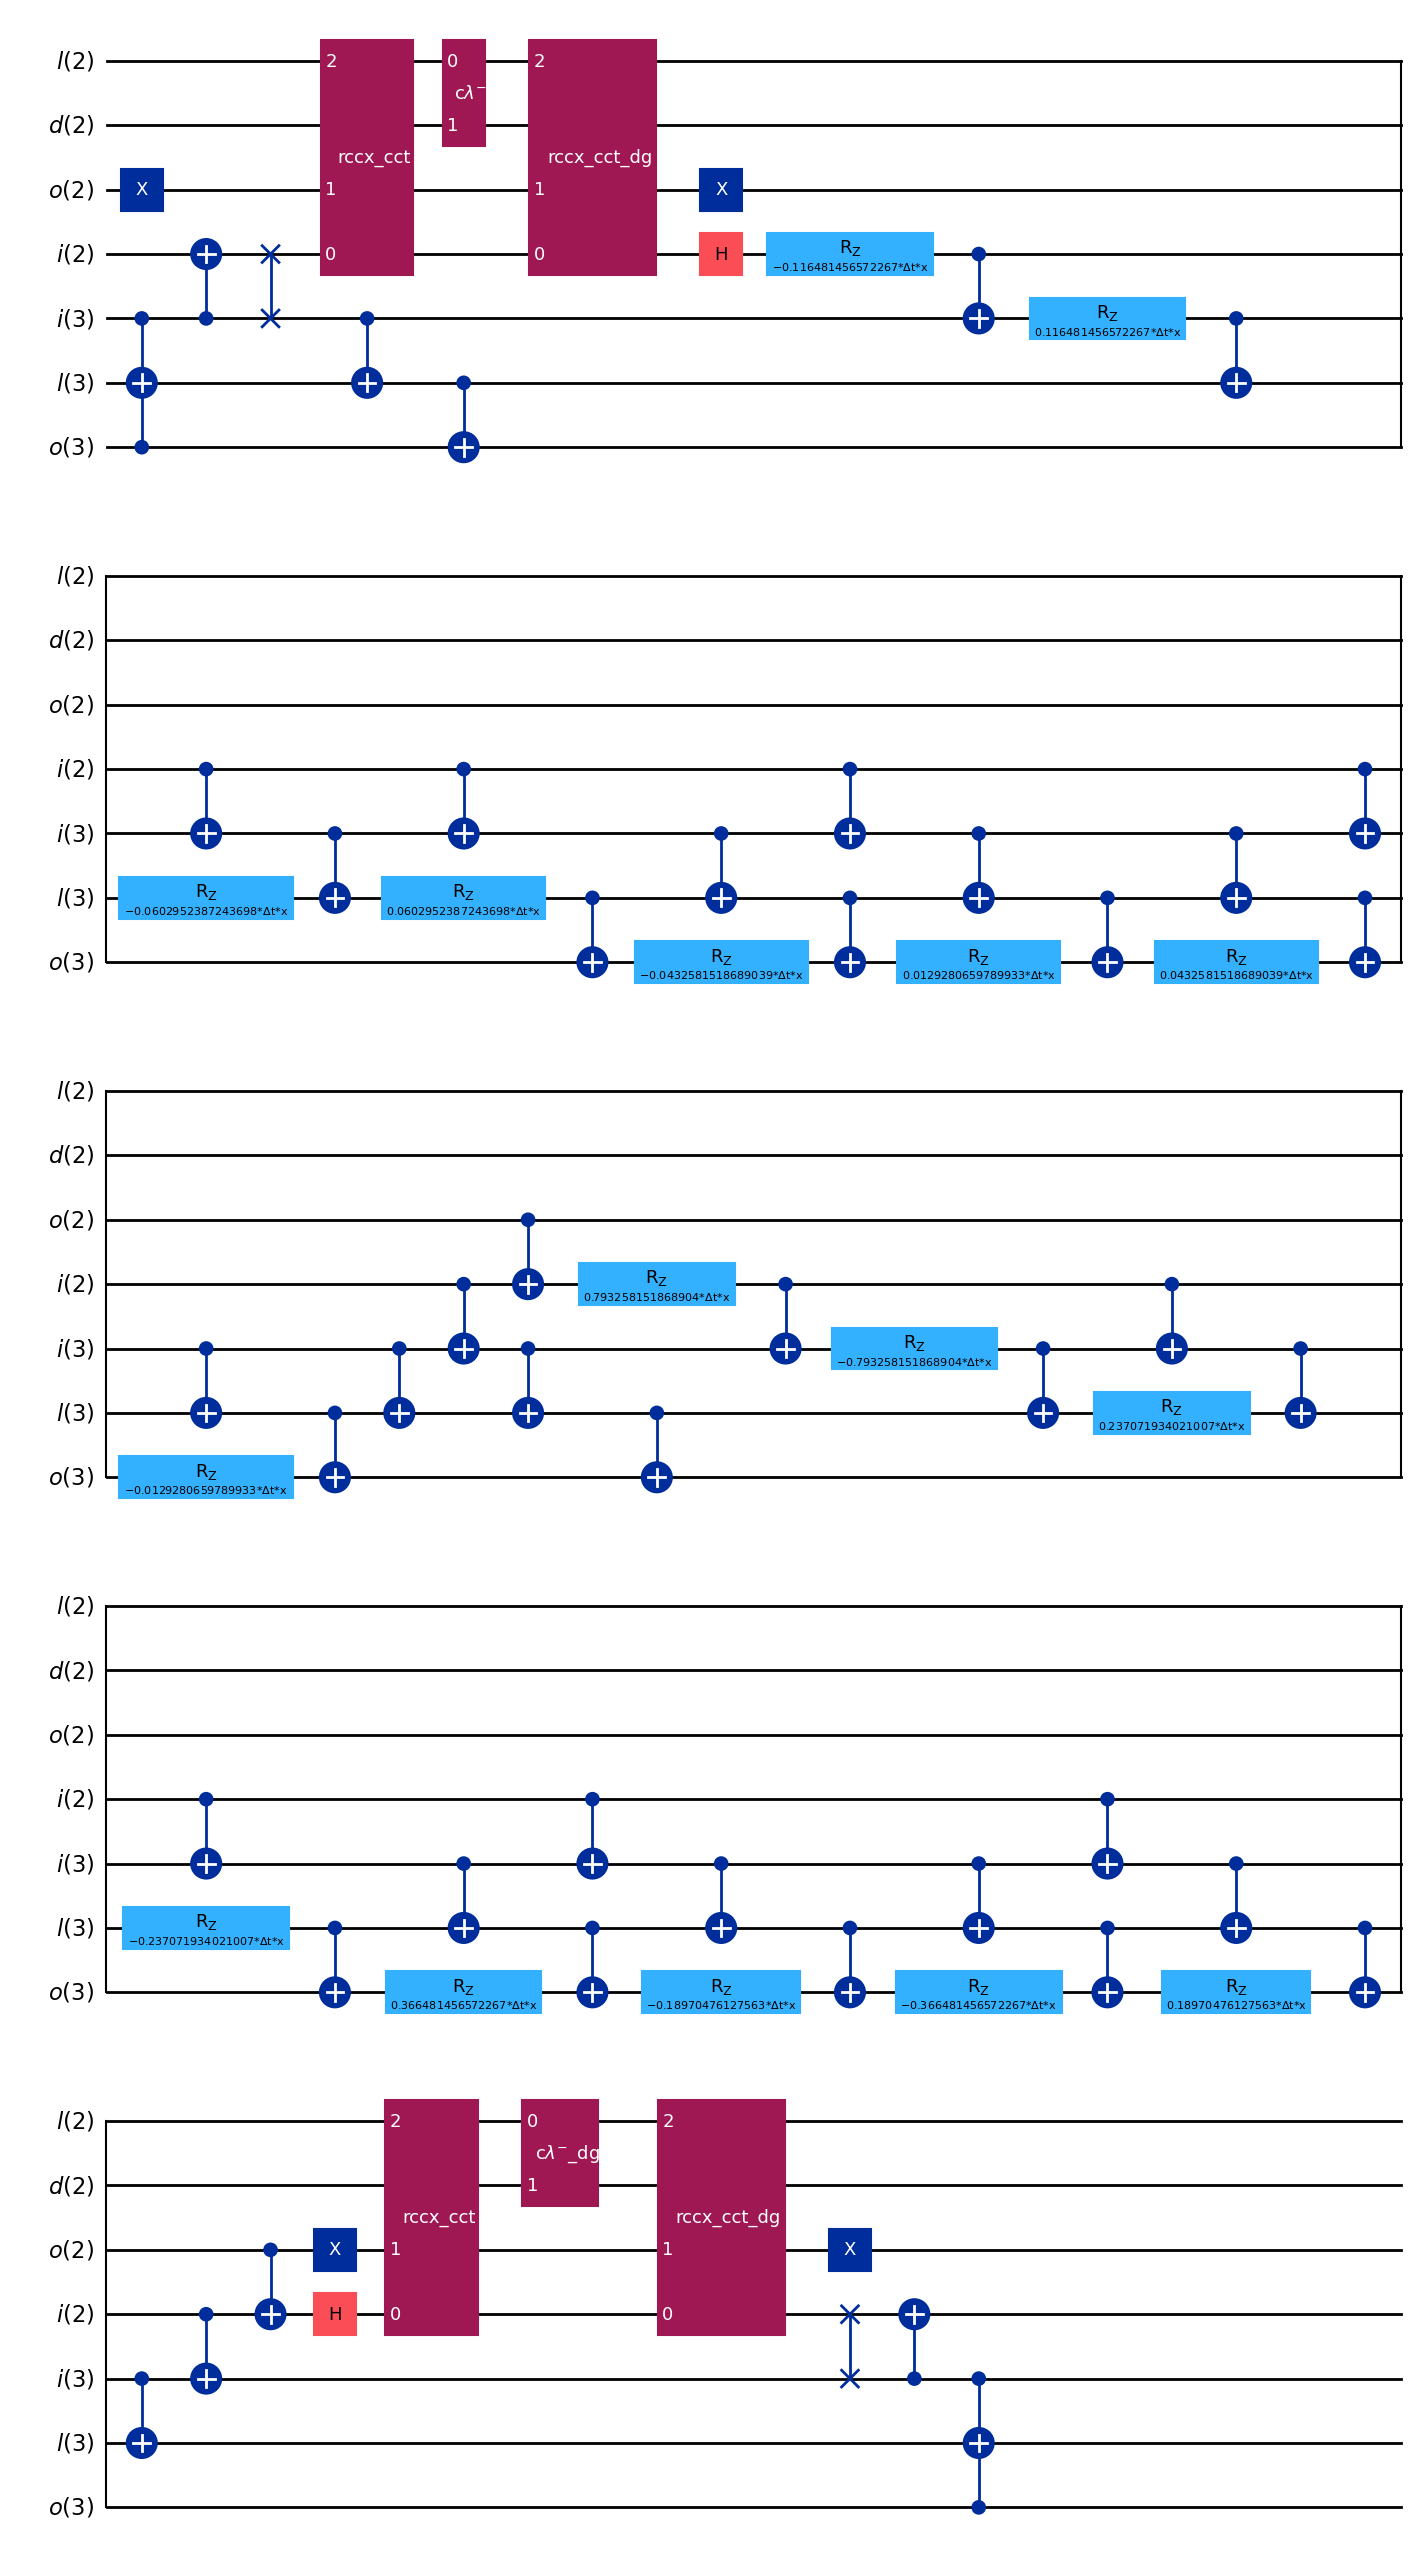

In [15]:
circuit, init_p, _ = hopping_term(1, 2, time_step, interaction_x, right_flux=(0, 1))
draw_circuit(circuit, init_p, reorder=False, fold=20)

In [16]:
assigned = circuit.decompose(custom_gates).assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('l', 3), ('o', 3), ('i', 3), ('l', 2), ('d', 2), ('o', 2), ('i', 2)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi1_mat.reshape(12, 4, 3, 12, 4, 3)[:, :, :2, :, :, :2].reshape(96, 96) * x * dt
subspace = np.sum(physical_states(right_flux=(0, 1), num_sites=2, as_multi=True) * np.cumprod([1, 2, 2, 2, 3, 2])[None, ::-1], axis=1)
validate_circuit(ordered, hmat, qutrits=(4,), ancillae=(3,), subspace=subspace)

True

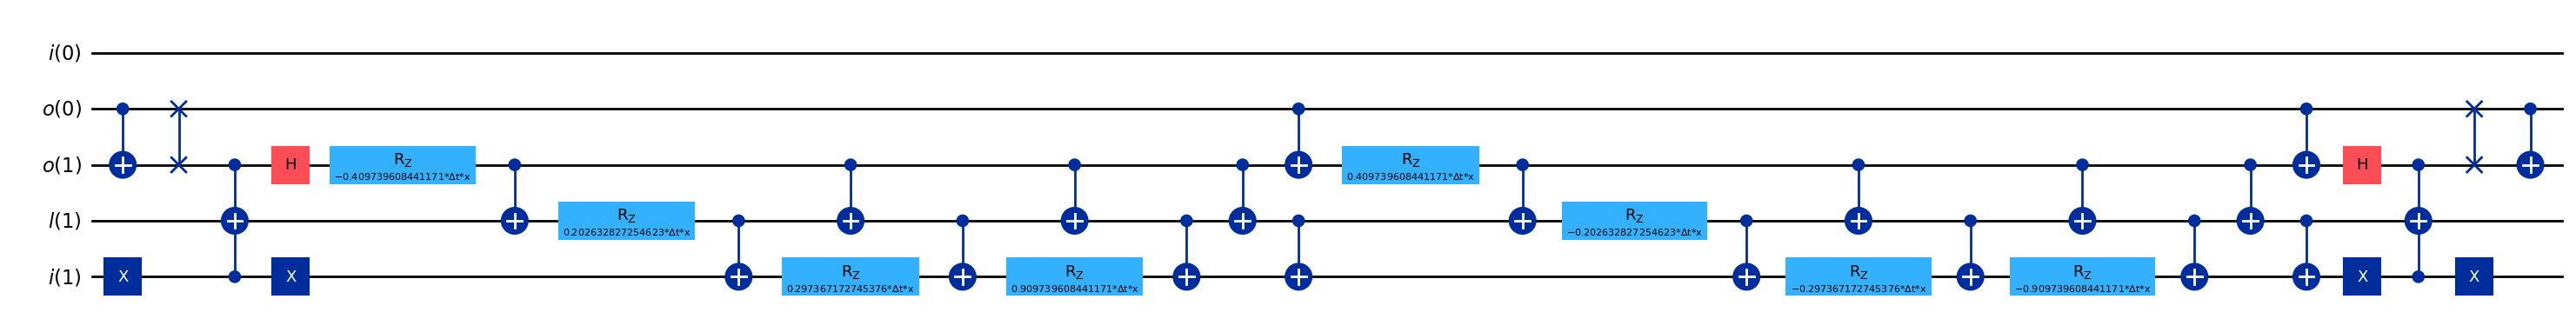

In [17]:
circuit, init_p, _ = hopping_term(2, 0, interaction_x, time_step, left_flux=0)
draw_circuit(circuit, init_p, reorder=False, fold=100)

In [18]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
embedded_qp = QubitPlacement([('l', 1), ('o', 1), ('i', 1), ('l', 0), ('o', 0), ('i', 0)])
embedded = QuantumCircuit(embedded_qp.num_qubits)
embedded.compose(assigned, qubits=[embedded_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi2_mat.reshape(4, 3, 4, 3, 4, 3, 4, 3)[:, :2, :, :2, :, :2, :, :2].reshape(64, 64) * x * dt
subspace = np.sum(physical_states(left_flux=0, num_sites=2, as_multi=True) << np.arange(6)[None, ::-1], axis=1)
validate_circuit(embedded, hmat, subspace=subspace)

True

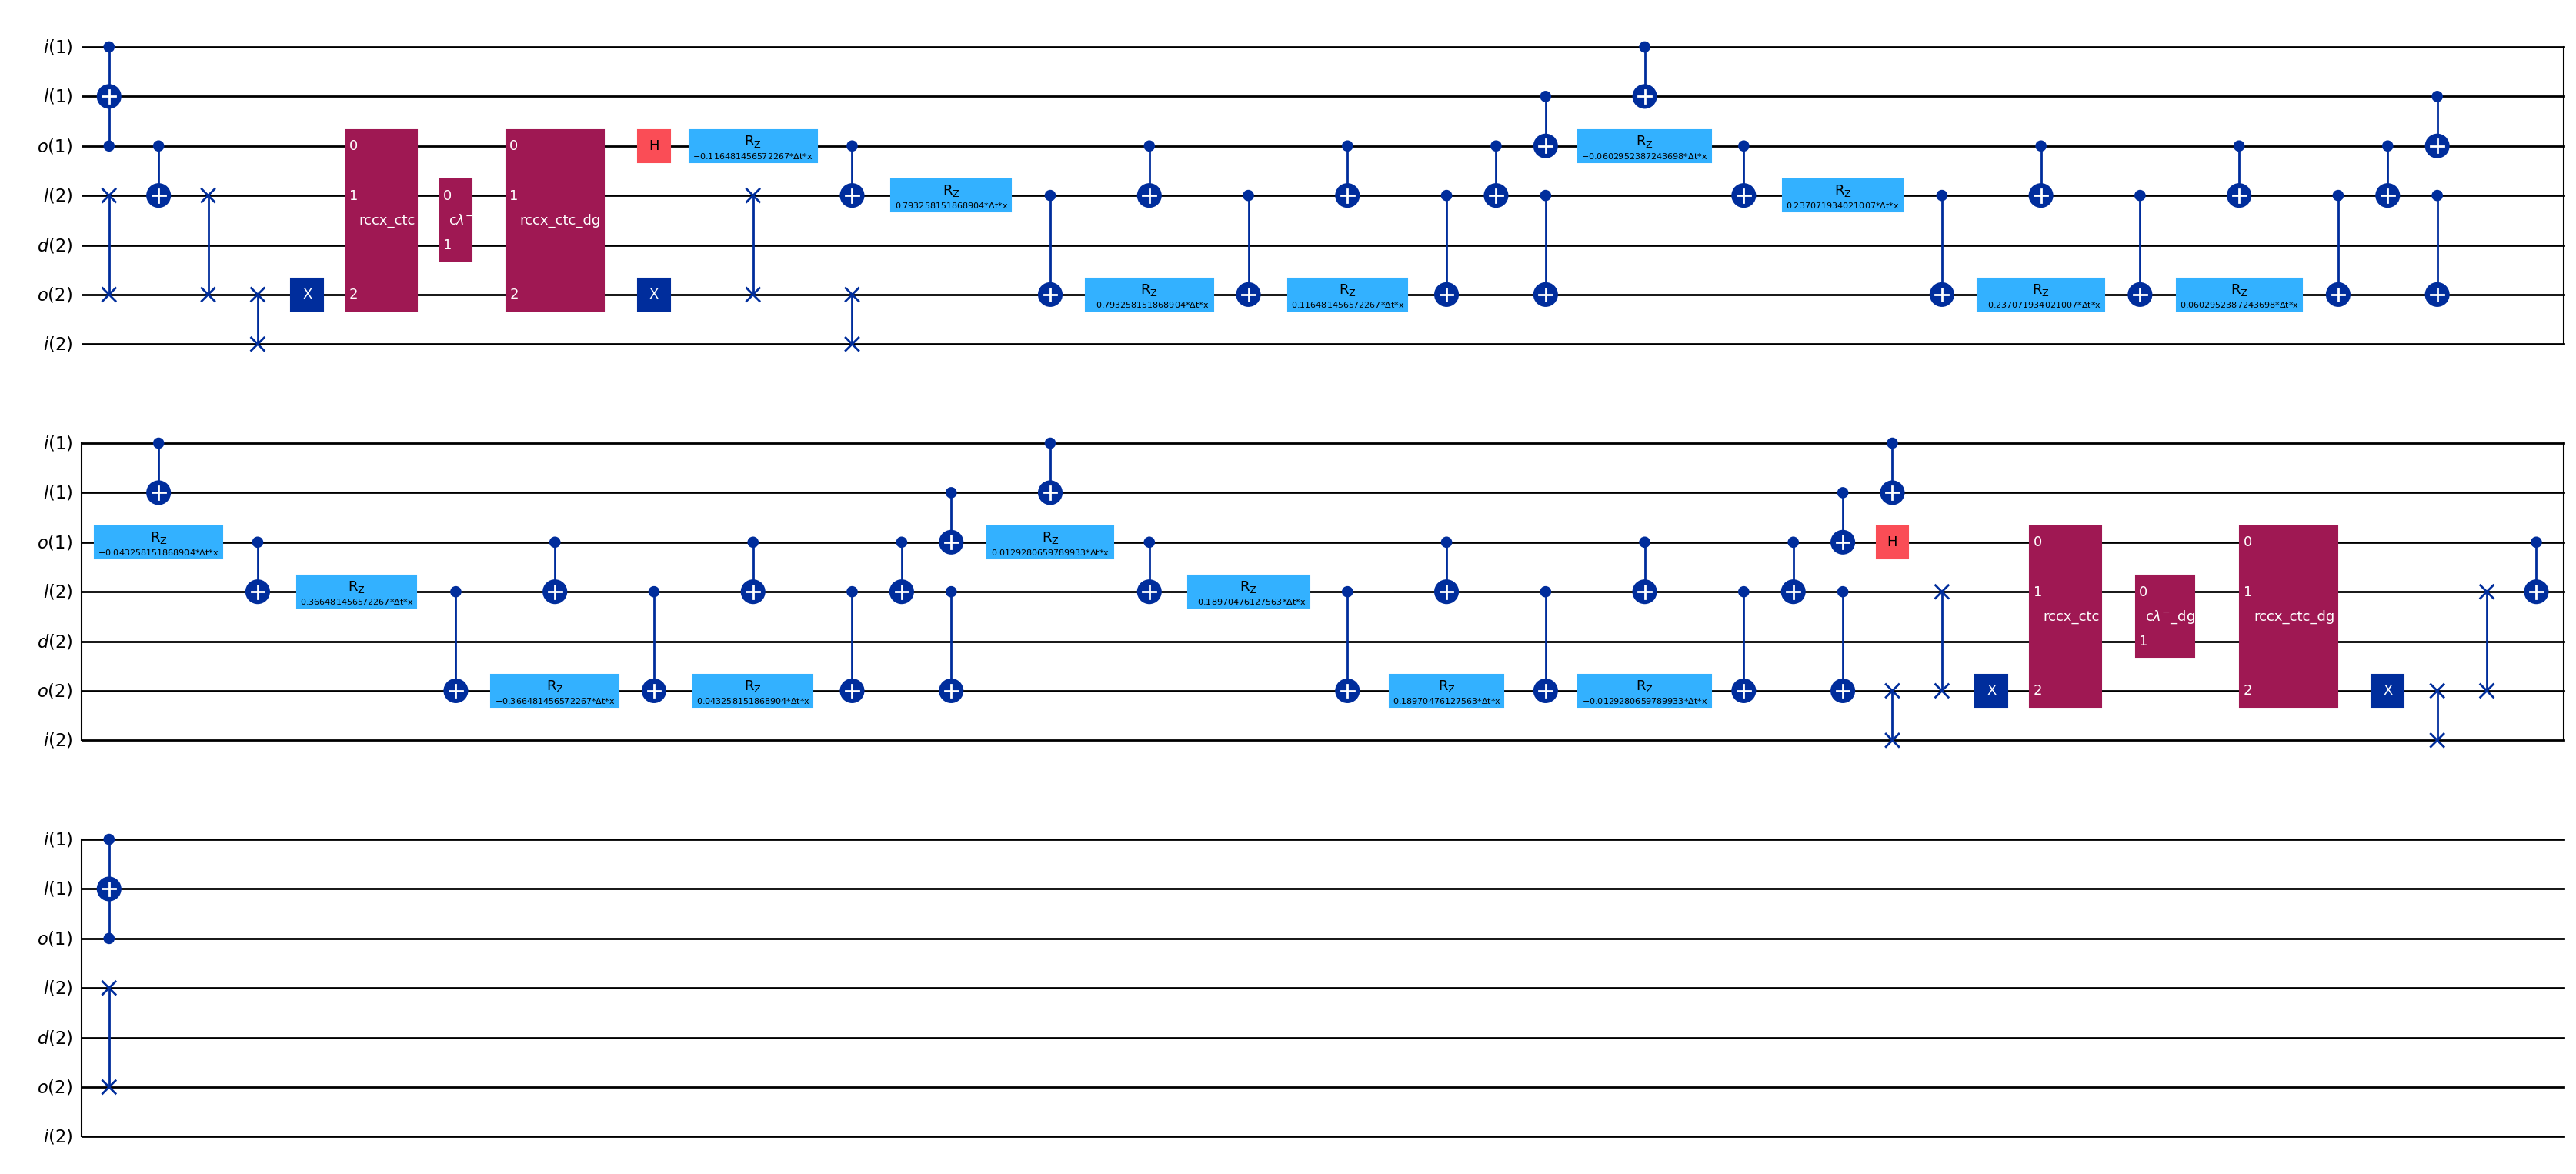

In [19]:
circuit, init_p, _ = hopping_term(2, 1, time_step, interaction_x, left_flux=(0, 1))
draw_circuit(circuit, init_p, reorder=False, fold=50)

In [20]:
assigned = circuit.decompose(custom_gates).assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('l', 2), ('d', 2), ('o', 2), ('i', 2), ('l', 1), ('o', 1), ('i', 1)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi2_mat.reshape(4, 3, 12, 4, 3, 12)[:, :2, :, :, :2, :].reshape(96, 96) * x * dt
subspace = np.sum(physical_states(left_flux=(0, 1), num_sites=2, as_multi=True) * np.cumprod([1, 3, 2, 2, 2, 2])[None, ::-1], axis=1)
validate_circuit(ordered, hmat, qutrits=(1,), ancillae=(0,), subspace=subspace)

True

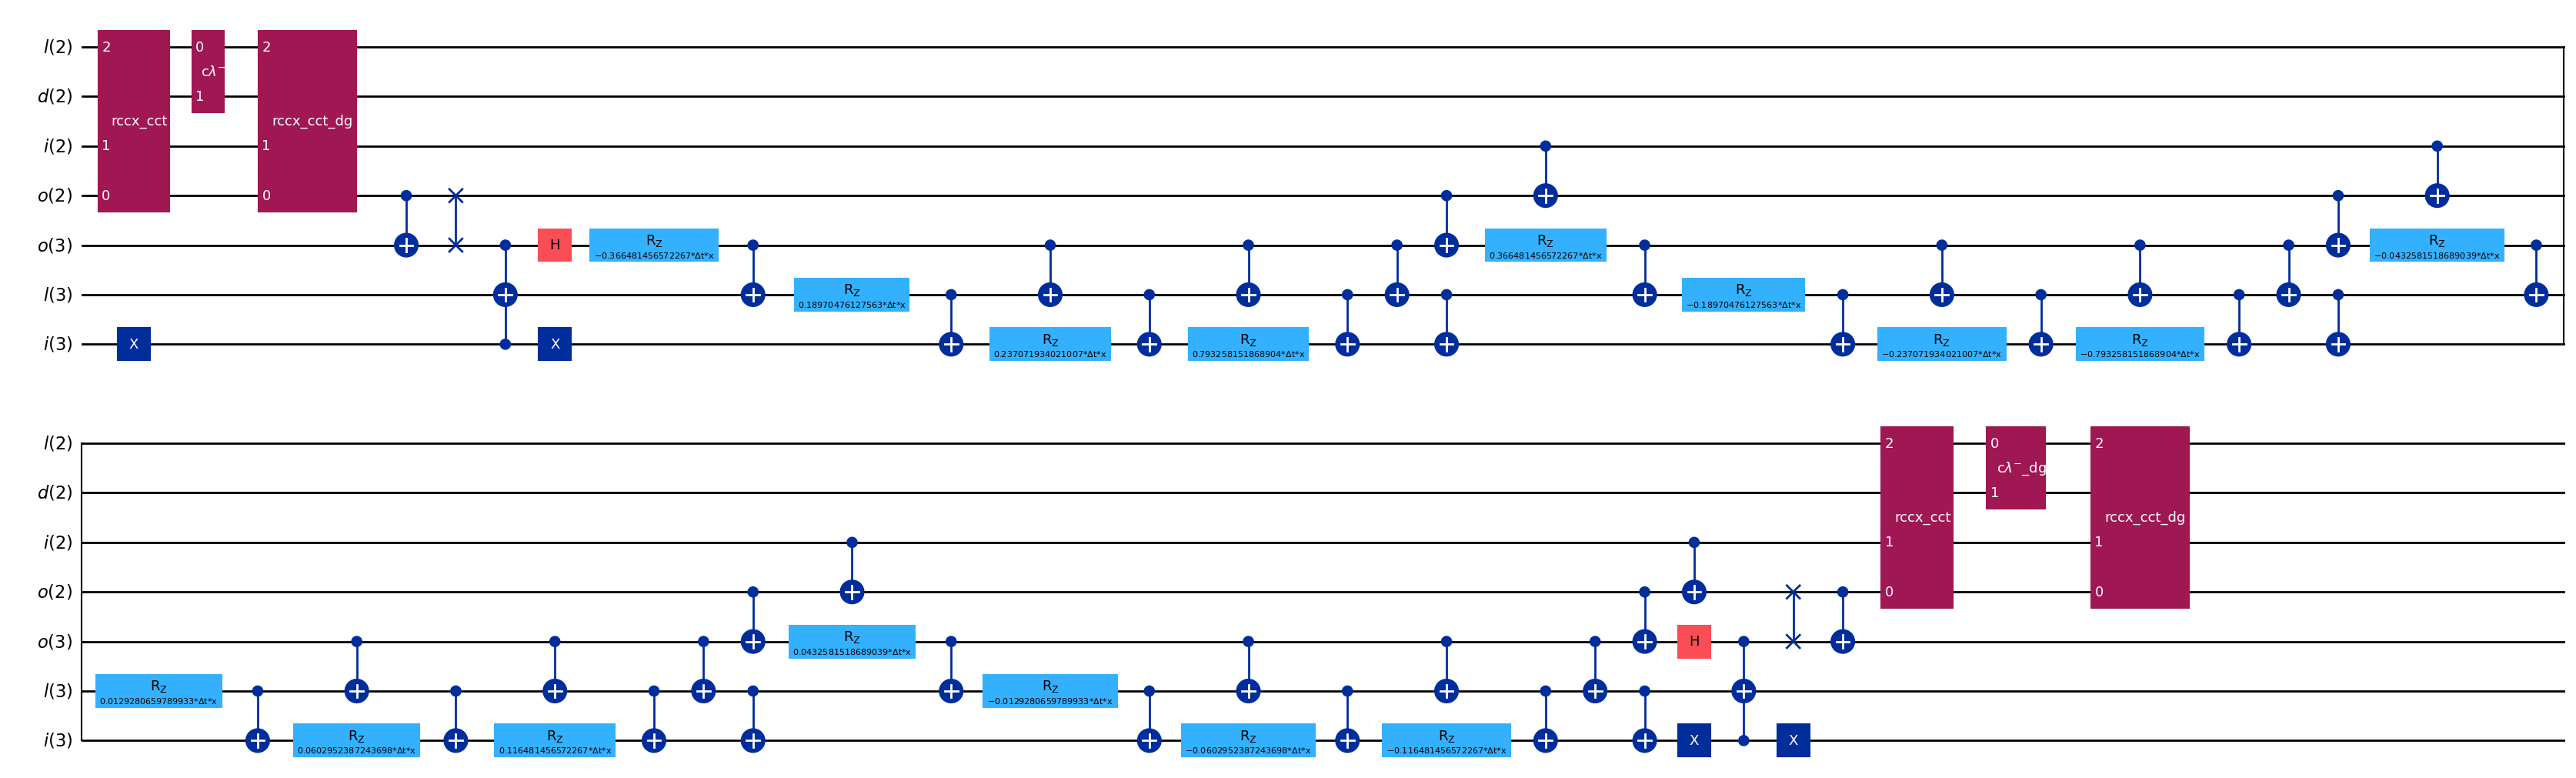

In [21]:
circuit, init_p, _ = hopping_term(2, 2, time_step, interaction_x, right_flux=(0, 1))
draw_circuit(circuit, init_p, reorder=False, fold=50)

In [22]:
assigned = circuit.decompose(custom_gates).assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('l', 3), ('o', 3), ('i', 3), ('l', 2), ('d', 2), ('o', 2), ('i', 2)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi2_mat.reshape(12, 4, 3, 12, 4, 3)[:, :, :2, :, :, :2].reshape(96, 96) * x * dt
subspace = np.sum(physical_states(right_flux=(0, 1), num_sites=2, as_multi=True) * np.cumprod([1, 2, 2, 2, 3, 2])[None, ::-1], axis=1)
validate_circuit(ordered, hmat, qutrits=(4,), ancillae=(3,), subspace=subspace)

True

## Full circuit